# Imports

In [221]:

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Load datasets

In [222]:
import data_func.read_data as read_data

dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()


# Data clean up

In [223]:
# Making sure that target values line up with x_values

def data_allign(x_train, y_train):
  
  y_train.dropna(inplace=True)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train

import data_func.aggregation as data_agg

categorical_features = ['date_forecast', 'dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx', 'precip_type_5min:idx']
categorical_features_to_drop = ['dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_train)):
  categorical_frame = X_frames_train[i][categorical_features]
  categorical_frame = data_agg.gen_agg(categorical_frame, data_agg.stocastic_median)
  
  X_frames_train[i] = X_frames_train[i].drop(columns=categorical_features_to_drop)
  X_frames_train[i] = data_agg.gen_agg(X_frames_train[i], 'mean')
  X_frames_train[i] = pd.merge(X_frames_train[i], categorical_frame, on='date_forecast')
  X_frames_train[i], Y_frames_train[i] = data_allign(X_frames_train[i], Y_frames_train[i])

for j in range(len(X_frames_test)):
  categorical_frame = X_frames_test[j][categorical_features]
  categorical_frame = data_agg.gen_agg(categorical_frame, data_agg.stocastic_median)
  categorical_features_to_drop.append('date_calc')

  X_frames_test[j] = X_frames_test[j].drop(columns=categorical_features_to_drop)
  X_frames_test[j] = data_agg.gen_agg(X_frames_test[j], 'mean')
  X_frames_test[j] = pd.merge(X_frames_test[j], categorical_frame, on='date_forecast')
  

print(len(X_frames_train[0]))
print(len(Y_frames_train[0]))
print(len(X_frames_test[2]))


29667
29667
720


# Feature engineering

In [224]:
import data_func.timeseasonality as DTS
import data_func.date_forecast as DTF
import data_func.one_hot_encoding as OHE

categorical_features = ['dew_or_rime:idx', 'precip_type_5min:idx']


for i in range(len(X_frames_train)):
    X_frames_train[i] = DTS.append_seasonal_columns(X_frames_train[i])
    X_frames_train[i] = DTF.date_forecast_columns(X_frames_train[i])
    # X_frames_train[i] = OHE.one_hot_encode(X_frames_train[i], categorical_features)
    X_frames_train[i].drop(columns=['snow_drift:idx'], inplace=True)
    # X_frames_train[i].drop(columns=['air_density_2m:kgm3'], inplace=True)
    # X_frames_train[i]['ceiling_height_agl:m'] = X_frames_train[i]['ceiling_height_agl:m'].fillna(0)
    # X_frames_train[i]['cloud_base_agl:m'] = X_frames_train[i]['cloud_base_agl:m'].fillna(100000)



for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    X_frames_test[i] = DTF.date_forecast_columns(X_frames_test[i])
    # X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], categorical_features)
    X_frames_test[i].drop(columns=['snow_drift:idx'], inplace=True)


print(len(X_frames_train[0]), len(X_frames_train[1]), len(X_frames_train[2]))
print(len(X_frames_test[0]), len(X_frames_test[1]), len(X_frames_test[2]))



29667 29218 23141
720 720 720


# Training the model

In [225]:

# Split the data into training and validation sets

x_train_a, x_val_a, y_train_a, y_val_a = train_test_split(X_frames_train[0], Y_frames_train[0], test_size=0.17, random_state=42)
x_train_b, x_val_b, y_train_b, y_val_b = train_test_split(X_frames_train[1], Y_frames_train[1], test_size=0.17, random_state=42)
x_train_c, x_val_c, y_train_c, y_val_c = train_test_split(X_frames_train[2], Y_frames_train[2], test_size=0.17, random_state=42)

# Use params from hyperparameter tuning using optuna
params_a = {'random_state': 42, 'learning_rate': 0.039975576144155645, 'depth': 9, 'subsample': 0.4504678933801176, 'colsample_bylevel': 0.9773225861097778, 'min_data_in_leaf': 90}
params_b = {'random_state': 42, 'learning_rate': 0.023765834908014156, 'depth': 10, 'subsample': 0.8298593330195755, 'colsample_bylevel': 0.6060393047650714, 'min_data_in_leaf': 61}
params_c = {'random_state': 42, 'learning_rate': 0.060183973978509046, 'depth': 10, 'subsample': 0.28819995411353627, 'colsample_bylevel': 0.39818319507473743, 'min_data_in_leaf': 77}

model_a = CatBoostRegressor(**params_a)
model_b = CatBoostRegressor(**params_b)
model_c = CatBoostRegressor(**params_c)


model_a.fit(x_train_a, y_train_a)
model_b.fit(x_train_b, y_train_b)
model_c.fit(x_train_c, y_train_c)

0:	learn: 1163.5028841	total: 35.3ms	remaining: 35.3s
1:	learn: 1129.3742267	total: 60.1ms	remaining: 30s
2:	learn: 1095.9445590	total: 84ms	remaining: 27.9s
3:	learn: 1063.7150143	total: 106ms	remaining: 26.5s
4:	learn: 1033.1880491	total: 139ms	remaining: 27.6s
5:	learn: 1004.3241741	total: 188ms	remaining: 31.1s
6:	learn: 977.5510528	total: 211ms	remaining: 29.9s
7:	learn: 950.6151855	total: 234ms	remaining: 29s
8:	learn: 925.5741241	total: 270ms	remaining: 29.7s
9:	learn: 902.6690674	total: 332ms	remaining: 32.9s
10:	learn: 879.9590108	total: 357ms	remaining: 32.1s
11:	learn: 858.3166985	total: 380ms	remaining: 31.3s
12:	learn: 836.9901657	total: 402ms	remaining: 30.5s
13:	learn: 817.1958239	total: 432ms	remaining: 30.4s
14:	learn: 797.2270078	total: 486ms	remaining: 31.9s
15:	learn: 779.1444844	total: 509ms	remaining: 31.3s
16:	learn: 762.0651019	total: 532ms	remaining: 30.8s
17:	learn: 745.4941252	total: 556ms	remaining: 30.3s
18:	learn: 730.0846577	total: 578ms	remaining: 29.9s


# Evaluate prediction

In [226]:
# Evaluate the model based on the validation data

mse_a = mean_squared_error(y_val_a, model_a.predict(x_val_a))
print("MSE for A: ", mse_a)
mse_b = mean_squared_error(y_val_b, model_b.predict(x_val_b))
print("MSE for B: ", mse_b)
mse_c = mean_squared_error(y_val_c, model_c.predict(x_val_c))
print("MSE for C: ", mse_c)
print("Mean MSE: ", (mse_a + mse_b + mse_c) / 3)

# Evaluate the predictions

score_a = model_a.score(x_val_a, y_val_a)
score_b = model_b.score(x_val_b, y_val_b)
score_c = model_c.score(x_val_c, y_val_c)

print("Score A: ", score_a)
print("Score B: ", score_b)
print("Score C: ", score_c)
print('')

MSE for A:  133712.8630025523
MSE for B:  2849.350503781884
MSE for C:  1894.226093268127
Mean MSE:  46152.14653320078
Score A:  0.9026691956777537
Score B:  0.9260327130487758
Score C:  0.9365269325811423



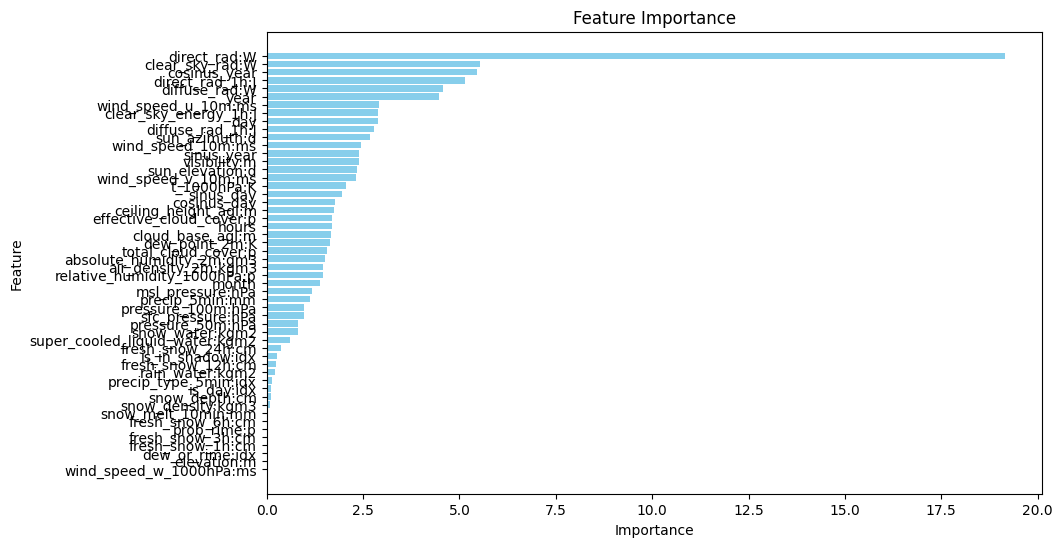

In [227]:
import matplotlib.pyplot as plt

feature_importance = model_a.get_feature_importance()
# Create a DataFrame to store feature names and their importance scores
importance_df = pd.DataFrame({'Feature': x_train_a.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance scores in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot to visualize feature importance

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
plt.show()

# Make predictions

In [228]:

# Train the model on the entire training data
model_a.fit(X_frames_train[0], Y_frames_train[0])
model_b.fit(X_frames_train[1], Y_frames_train[1])
model_c.fit(X_frames_train[2], Y_frames_train[2])

y_pred_a = model_a.predict(X_frames_test[0])
y_pred_b = model_b.predict(X_frames_test[1])
y_pred_c = model_c.predict(X_frames_test[2])
print(len(y_pred_a))

y_pred = np.concatenate((y_pred_a, y_pred_b, y_pred_c), axis=0)



0:	learn: 1159.0382316	total: 41.7ms	remaining: 41.7s
1:	learn: 1124.5222006	total: 66.4ms	remaining: 33.1s
2:	learn: 1091.0318836	total: 91.6ms	remaining: 30.4s
3:	learn: 1059.3256988	total: 123ms	remaining: 30.7s
4:	learn: 1029.0974704	total: 179ms	remaining: 35.6s
5:	learn: 1000.4218678	total: 205ms	remaining: 33.9s
6:	learn: 973.3157593	total: 231ms	remaining: 32.7s
7:	learn: 946.6371022	total: 266ms	remaining: 33s
8:	learn: 920.8886638	total: 315ms	remaining: 34.7s
9:	learn: 897.0036486	total: 338ms	remaining: 33.4s
10:	learn: 873.7620610	total: 362ms	remaining: 32.6s
11:	learn: 851.3964214	total: 401ms	remaining: 33s
12:	learn: 830.1141889	total: 456ms	remaining: 34.6s
13:	learn: 809.9592124	total: 479ms	remaining: 33.8s
14:	learn: 791.3720959	total: 502ms	remaining: 33s
15:	learn: 773.3511196	total: 534ms	remaining: 32.9s
16:	learn: 757.1126827	total: 581ms	remaining: 33.6s
17:	learn: 740.8999076	total: 603ms	remaining: 32.9s
18:	learn: 724.8730470	total: 626ms	remaining: 32.3s


In [229]:
print(len(y_pred_a), len(X_frames_test[0]))
print(len(y_pred_b), len(X_frames_test[1]))
print(len(y_pred_c), len(X_frames_test[2]))

720 720
720 720
720 720


In [230]:
for i in range(len(y_pred)):
    if y_pred[i] < 0: 
        y_pred[i] = 0



# Create submission

In [231]:
y_test_pred = y_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submission.csv', index=False)